In [134]:
%matplotlib notebook

%matplotlib ipympl

import numpy as np
import h5py
import matplotlib.pyplot as plt

# import boost_histogram as bh
# import hist
import mplhep

from ipywidgets import *

from geohelper import geohelper

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
class neighbor_finder:
    """Find out nearest neighbors
    """
    def __init__(self):
        self.points = np.array([])
        self.finder = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    def load_points(self, points):
        self.points = points
    def find_k_neighbors(self, points, k):
        if k > 1:
            self.finder = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
        elif k <=0:
            raise NotImplementedError("k must be non-negative")
        self.finder.fit(self.points)
        distances, indices = self.finder.kneighbors(points)
        return distances, indices

In [4]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [5]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
print(sync_mask.shape)
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

(48479011,)
1201  packet groups partitioned by sync packets


In [181]:
def interactive_plot_adc(sync_group, counter, threshold, xypoints):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    xpos: float or array of float, x value of points of interest
    ypos: float or array of float, y value of points of interest
    threshold: minimum of threshold within a time duration
    """
    xypoints = np.array(xypoints)
    xpos = xypoints[:,0]
    ypos = xypoints[:,1]

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')


    t0 = physics_bins[counter]*bin_width
    t1 = physics_bins[counter]*bin_width+bin_width

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp


    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    ############
    fig = plt.figure(figsize=(10, 5));
    ax3d = fig.add_subplot(131, projection='3d')
    axslice = fig.add_subplot(132)
    axadc = fig.add_subplot(133)
    
    def plot_3d():
        ax3d.clear()
        ax3d.scatter(timestamp, x, y, s=1)
    
        plt.tight_layout()

    def plot_adc_slice(updatebutton):
        axslice.clear()
        x0, x1 = ax3d.get_xlim()
        y0, y1 = ax3d.get_ylim()
        z0, z1 = ax3d.get_zlim()
        print("x range:", y0, y1, "[some unit]")
        print("y range:", z0, z1, "[some unit]")
        print("t range:", x0, x1, "[some unit]")
        t0 = x0
        t1 = x1

        adcmask = (timestamp > x0) & (timestamp < x1) & (x > y0) & (x < y1) & (y > z0) & (y < z1)

        nbins = 50
        counts, bins = np.histogram(timestamp[adcmask], bins=nbins, range=(t0, t1), weights=dataword[adcmask])
        axslice.stairs(counts, bins)
        print(counts)

        # plt.show()
 
    k_w = widgets.IntSlider(value=1, min=1, max=5, description='k nearest points', layout={"width": '500px'})
    trange_w = widgets.FloatRangeSlider(value=(t0, t1), min=t0, max=t1, description="time stamp min", layout={"width": '500px'})   
    def plot_adc(trange, k=1):
        axadc.clear()

        tmin = trange[0]
        tmax = trange[1]

        adcmask = (timestamp > t0) & (timestamp < t1) & dataword > 0
        xvalid = x[adcmask]
        yvalid = y[adcmask]
        xyvalid = np.stack([xvalid, yvalid]).transpose()

        nearestxy = neighbor_finder()
        nearestxy.load_points(xyvalid)
    
        nbins = 50
    
        counts = []
        labels = []

        for i, j in zip(xpos, ypos):
            # print(k)
            distances, indices = nearestxy.find_k_neighbors([[i, j]], k=k)
            for idx in indices[0]:
                tileid, chipid, channelid = helper.find_ids(xvalid[idx], yvalid[idx])
                labels.append("({:.1f},{:.1f})->({:.1f},{:.1f})->{}:{}:{}".format(i, j, xvalid[idx], yvalid[idx], tileid, chipid, channelid))
                idmask = (tile_id == tileid) & (chip_id == chipid) & (channel_id == channelid)
                h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
                # print(h, bins)
                counts.append(h)
                axadc.stairs(h, bins, label=labels[-1])

        #mplhep.histplot(counts, bins, ax=ax, yerr=False, label=labels)
        # ax.plot(bins, counts)
        axadc.set_ylabel("ADC sum per {} [0.1 us]".format(bin_width/nbins))
        axadc.set_xlabel("Timestamp [0.1 us]")
        axadc.legend()

        # display(fig)

        # plt.show()


    plot_3d()
    plot_adc_slice(None)
    
    button = widgets.Button(description="Update middle plot") 
    output = widgets.Output()

    # middle_plot = interactive_output(plot_adc_slice, {"updatebutton": button})
    display(button, output)

    button.on_click(plot_adc_slice)

    
    interactive_plot = interactive_output(plot_adc, {"trange" : trange_w, "k" : k_w})
    display(widgets.VBox([trange_w, k_w]), interactive_plot)

27598  data packets between syncs
14  candidate events
595  hits in event
x range: -353.10343750000004 353.10343750000004 [some unit]
y range: -686.1153125 375.7353125 [some unit]
t range: 2178779.895833333 2198880.104166667 [some unit]
[  0   0   0  39   0   0   0   0   0   0   0   0 168   0  80   0   0   0
   0   0 102   0   0   0 109   0 105 142 151   0   0  84   0  21  83   0
   0   0   0   8  25 103 254   0   0   0 166   0   0   0]


Button(description='Update middle plot', style=ButtonStyle())

Output()

Output()

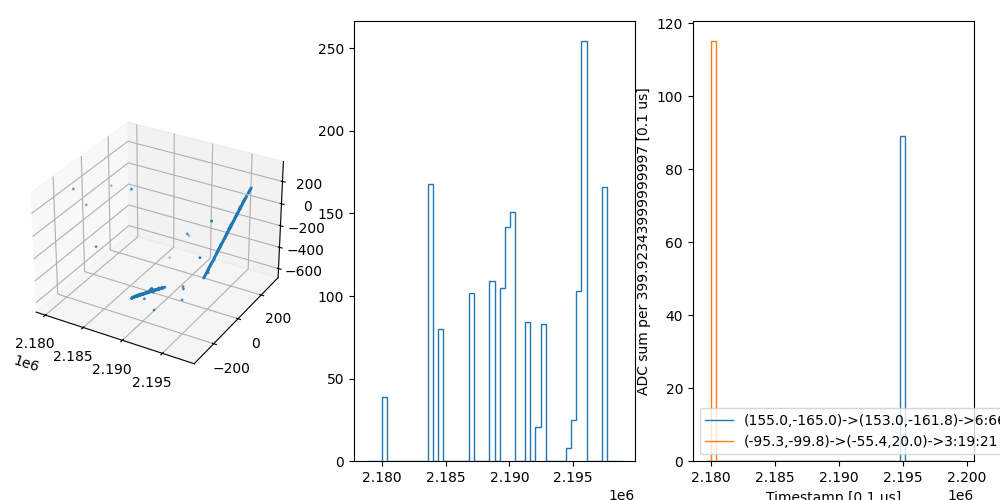

In [182]:
interactive_plot_adc(0, 0, 500, [[155, -165], [-95.331, -99.765]])